In [1]:
from darkspirals.disc import Disc
from darkspirals.substructure.realization import SubstructureRealization
from galpy.potential import MWPotential2014
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import astropy.units as apu
from darkspirals.orbit_util import integrate_single_orbit
from darkspirals.substructure.dsphr import PopulationdSphr

seed_subhalos = 1769

plt.rcParams['axes.linewidth'] = 2.
plt.rcParams['xtick.major.width'] = 2.
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.width'] = 1.0
plt.rcParams['xtick.minor.size'] = 3.5
plt.rcParams['ytick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.width'] = 1.0
plt.rcParams['ytick.minor.size'] = 3.5
plt.rcParams.update({'font.size': 16})

A new version of galpy (1.10.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
z_min_max = 1.5
vz_min_max = 100
phase_space_resolution = 60
z = np.linspace(-z_min_max,z_min_max,phase_space_resolution)
vz = np.linspace(-vz_min_max, vz_min_max, phase_space_resolution)
galactic_potential = MWPotential2014
#time_Gyr = np.linspace(-2.4, 0.0, 800) * apu.Gyr
time_Gyr = np.linspace(0.0, -1.2, 1000) * apu.Gyr
disc = Disc(galactic_potential, galactic_potential, z_min_max, vz_min_max, phase_space_resolution, 
                time_Gyr, parallelize_action_angle_computation=True, compute_upfront=True)

In [3]:
np.random.seed(seed_subhalos) 
r_min = 40
realization = SubstructureRealization.withDistanceCut(disc, norm=1500, r_min=r_min, 
                                                      num_halos_scale=1.0, 
                                                      m_low=10**5.7, 
                                                      m_high=10**8.0, 
                                                      t_max=-1.2)
print('realization contains : ', len(realization.subhalo_masses))

realization contains :  3201


In [4]:
force_list = []
mass_list = []
deltaJ_list_subhalos = []
vimpact_list = []
rimpact_list = []
vimpact_list_rel = []

j0 = 11.78 / (8 * 220)

for i, (subhalo_mass, subhalo_orbit, subhalo_potential) in enumerate(zip(realization.subhalo_masses, 
                                                          realization.subhalo_orbits, 
                                                          realization.subhalo_potentials)): 
    if i%100==0:
        percent = i*100/len(realization.subhalo_masses)
        print(str(np.round(percent, 1))+'% ')
    
    f = subhalo_orbit.force_exerted(disc, physical_units=True)
    mass_list.append(subhalo_mass)
    force_list.append(np.max(np.absolute(f)))
    dj = subhalo_orbit.deltaJ(disc, physical_units=False)
    deltaJ_list_subhalos.append(np.mean(np.absolute(dj) / j0))
    vimpact_list.append(subhalo_orbit.impact_velocity(disc, relative=False))
    vimpact_list_rel.append(subhalo_orbit.impact_velocity(disc, relative=True))
    rimpact_list.append(subhalo_orbit.closest_approach)

0.0% 
3.1% 
6.2% 
9.4% 
12.5% 
15.6% 
18.7% 
21.9% 
25.0% 
28.1% 
31.2% 
34.4% 
37.5% 
40.6% 
43.7% 
46.9% 
50.0% 
53.1% 
56.2% 
59.4% 
62.5% 
65.6% 
68.7% 
71.9% 
75.0% 
78.1% 
81.2% 
84.3% 
87.5% 
90.6% 
93.7% 
96.8% 
100.0% 


In [5]:
filename = 'dsphr_orbit_params.txt'

with open(filename, 'r') as f:
    dsphr_orbit_params =  eval(f.read())
f.close()
dwarf_galaxy_names = list(dsphr_orbit_params.keys())
cmap_dwarfs = plt.colormaps['jet']
dwarf_galaxy_colors = [cmap_dwarfs(i / len(dsphr_orbit_params)) for i in
                       range(0, len(dsphr_orbit_params))]

print(list(dsphr_orbit_params['Tucana III'].keys()))

['log10_fmax', 'log10_fmax_sigma', 'log10_deltaJ', 'log10_deltaJ_sigma', 'r_min', 'r_min_sigma', 'v-impact', 'v-impact_sigma', 'tau', 'tau_sigma', 'm_peak', 'v-impact_rel', 'v-impact_rel_sigma']


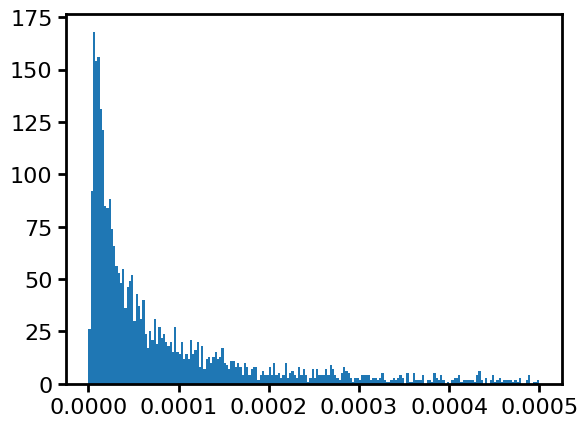

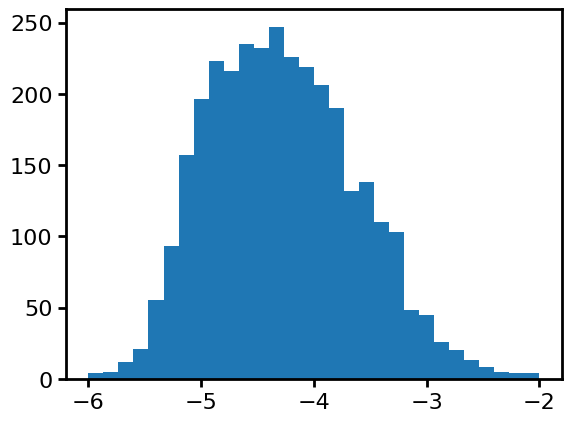

In [32]:
plt.hist(deltaJ_list_subhalos,bins=200,range=(0, 0.0005)); plt.show()

plt.hist(np.log10(deltaJ_list_subhalos),bins=30,range=(-6,-2)); plt.show()

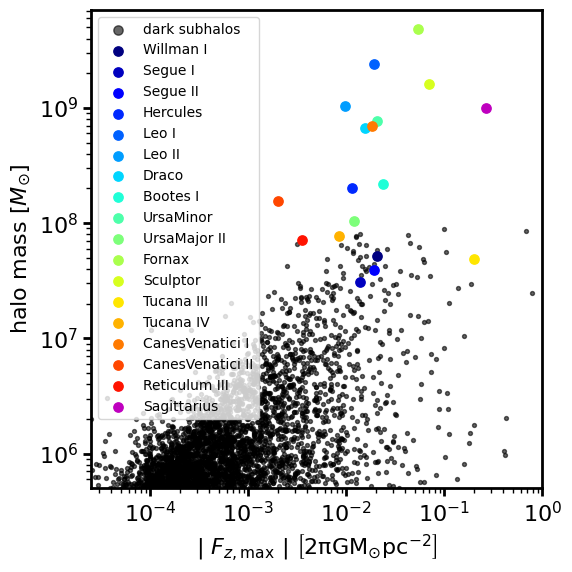

In [33]:
fig = plt.figure(1)
fig.set_size_inches(6,6)
ax = plt.subplot(111)
ax.scatter(force_list, mass_list, color='k', alpha=0.6, s=8)
i_max = len(dsphr_orbit_params)-1

ax.scatter(1e4, 1e4, color='k', alpha=0.6, s=45, label='dark subhalos')

for i in range(0, len(dsphr_orbit_params)):
    if i==i_max:
        col = 'm'
    else:
        col = dwarf_galaxy_colors[i]
    label = dwarf_galaxy_names[i]
    ax.scatter(10**dsphr_orbit_params[label]['log10_fmax'], 10**dsphr_orbit_params[label]['m_peak'], color=col, 
               s=45, alpha=1.0, label=label)

ax.set_xlim(0.000025, 1.)
ax.set_ylim(10**5.7, 10**9.85)
ax.legend(frameon=True,loc=2, fontsize=10.,ncol=1)    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$|\ F_{z,\rm{max}} \ | \ \left[\rm{2\pi G M_{\odot}} \rm{pc^{-2}}\right]$', fontsize=16)
ax.set_ylabel('halo mass '+r'$\left[M_{\odot}\right]$', fontsize=16)
plt.tight_layout() 
plt.savefig('fmax_vs_halomass.pdf')
plt.show()

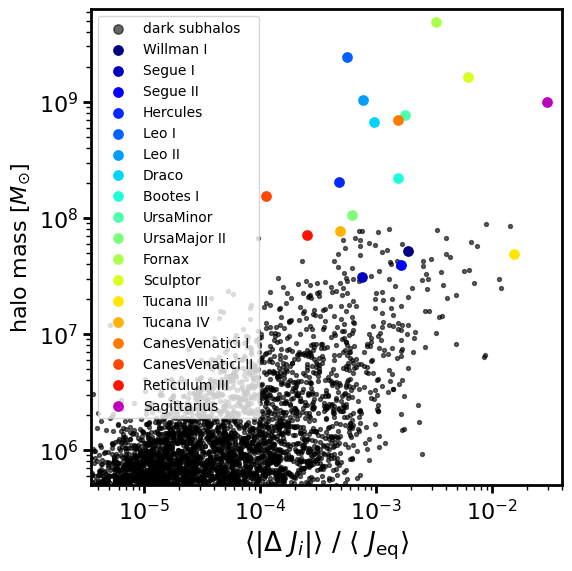

In [34]:
fig = plt.figure(2)
fig.set_size_inches(6,6)
ax = plt.subplot(111)

ax.scatter(1e4, 1e4, color='k', alpha=0.6, s=45, label='dark subhalos')
ax.scatter(deltaJ_list_subhalos, mass_list, color='k', alpha=0.6, s=8)
i_max = len(dsphr_orbit_params)-1

for i in range(0, len(dsphr_orbit_params)):
    if i==i_max:
        col = 'm'
    else:
        col = dwarf_galaxy_colors[i]
    label = dwarf_galaxy_names[i]
    ax.scatter(10**dsphr_orbit_params[label]['log10_deltaJ'], 10**dsphr_orbit_params[label]['m_peak'], color=col, 
                s=45, alpha=1.0, label=label)

ax.set_xlim(3.5e-6, 4.e-2)
ax.set_ylim(10**5.7, 10**9.8)
ax.legend(frameon=True,loc=2, fontsize=10)    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\langle | \Delta \ J_{i} | \rangle \ /  \ \langle \ J_{\rm{eq}} \rangle$', fontsize=19)
ax.set_ylabel('halo mass '+r'$\left[M_{\odot}\right]$', fontsize=16)
plt.tight_layout() 
plt.savefig('deltaJ_vs_halomass.pdf')
plt.show()

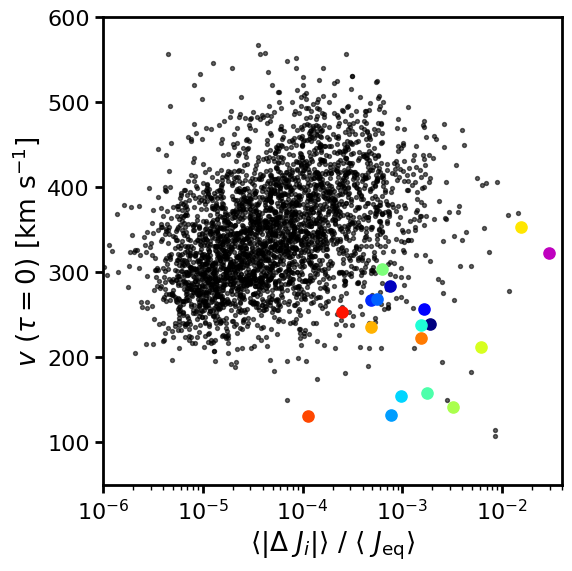

In [35]:
fig = plt.figure(3)
fig.set_size_inches(6,6)
ax = plt.subplot(111)

ax.scatter(deltaJ_list_subhalos, vimpact_list, color='k', alpha=0.6, s=8)
i_max = len(dsphr_orbit_params)-1
for i in range(0, len(dsphr_orbit_params)):
    if i==i_max:
        col = 'm'
    else:
        col = dwarf_galaxy_colors[i]
    label = dwarf_galaxy_names[i]
    ax.scatter(10**dsphr_orbit_params[label]['log10_deltaJ'], dsphr_orbit_params[label]['v-impact'], color=col, s=65, alpha=1.0, label=label)
ax.scatter(1e4, 1e4, color='k', alpha=0.6, s=45, label='dark subhalos')
ax.set_xlim(1e-6, 4e-2)
ax.set_ylim(50.0, 600.0)
#ax.legend(frameon=True,loc=2, fontsize=11.5)    
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set
ax.set_xlabel(r'$\langle | \Delta \ J_{i} | \rangle \ /  \ \langle \ J_{\rm{eq}} \rangle$', fontsize=19)
ax.set_ylabel(r'$v \ \left(\tau = 0\right) \ \left[\rm{km} \ \rm{s^{-1}}\right]$', fontsize=19)
plt.tight_layout() 
plt.savefig('deltaJ_vs_vimpact.pdf')
plt.show()

3201 3201


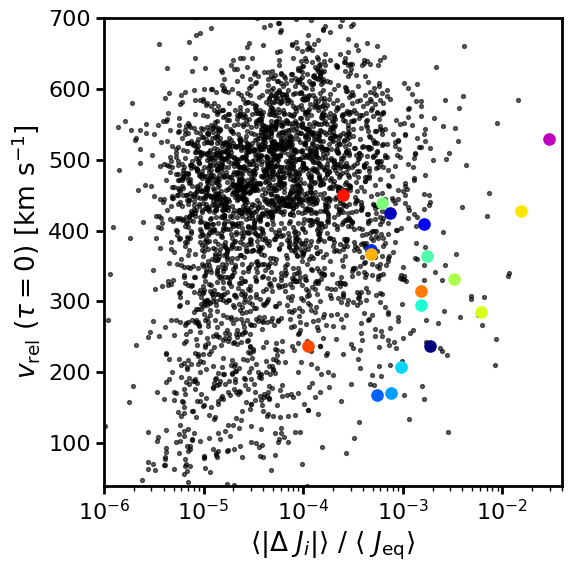

In [36]:
fig = plt.figure(3)
fig.set_size_inches(6,6)
ax = plt.subplot(111)
print(len(deltaJ_list_subhalos), len(vimpact_list_rel))

ax.scatter(deltaJ_list_subhalos, vimpact_list_rel, color='k', alpha=0.6, s=8)
i_max = len(dsphr_orbit_params)-1
for i in range(0, len(dsphr_orbit_params)):
    if i==i_max:
        col = 'm'
    else:
        col = dwarf_galaxy_colors[i]
    label = dwarf_galaxy_names[i]
    ax.scatter(10**dsphr_orbit_params[label]['log10_deltaJ'], dsphr_orbit_params[label]['v-impact_rel'], color=col, s=65, alpha=1.0, label=label)
ax.scatter(1e4, 1e4, color='k', alpha=0.6, s=45, label='dark subhalos')
ax.set_xlim(1e-6, 4e-2)
ax.set_ylim(40.0, 700.0)
#ax.legend(frameon=True,loc=2, fontsize=11.5)    
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set
ax.set_xlabel(r'$\langle | \Delta \ J_{i} | \rangle \ /  \ \langle \ J_{\rm{eq}} \rangle$', fontsize=19)
ax.set_ylabel(r'$v_{\rm{rel}} \ \left(\tau = 0\right) \ \left[\rm{km} \ \rm{s^{-1}}\right]$', fontsize=19)
plt.tight_layout() 
plt.savefig('deltaJ_vs_vimpact_rel.pdf')
plt.show()

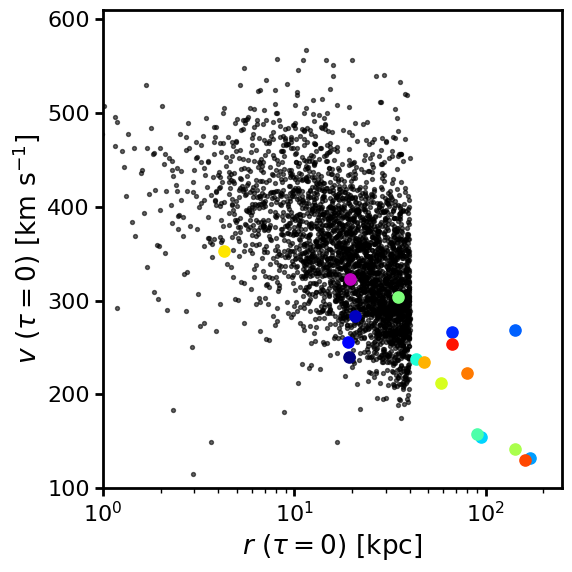

In [37]:
fig = plt.figure(4)
fig.set_size_inches(6,6)
ax = plt.subplot(111)
ax.scatter(np.array(rimpact_list), np.array(vimpact_list), color='k', alpha=0.6, s=8)
i_max = len(dsphr_orbit_params)-1
for i in range(0, len(dsphr_orbit_params)):
    if i==i_max:
        col = 'm'
    else:
        col = dwarf_galaxy_colors[i]
    label = dwarf_galaxy_names[i]
    ax.scatter(dsphr_orbit_params[label]['r_min'], dsphr_orbit_params[label]['v-impact'], color=col, s=65, alpha=1.0, label=label)
ax.scatter(1e4, 1e4, color='k', alpha=0.6, s=45, label='dark subhalos')
ax.set_xlim(1, 250)
ax.set_ylim(100.0, 610.0)
#ax.legend(frameon=True,loc=2, fontsize=11.5)    
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r'$r \ \left(\tau = 0\right) \ \left[\rm{kpc}\right]$', fontsize=19)
ax.set_ylabel(r'$v \ \left(\tau = 0\right) \ \left[\rm{km} \ \rm{s^{-1}}\right]$', fontsize=19)
plt.tight_layout() 
plt.savefig('rimpact_vs_vimpact.pdf')
plt.show()

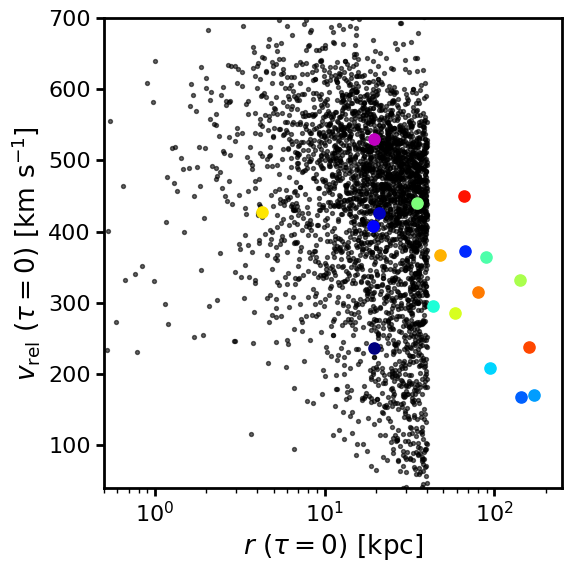

In [38]:
fig = plt.figure(4)
fig.set_size_inches(6,6)
ax = plt.subplot(111)
ax.scatter(np.array(rimpact_list), np.array(vimpact_list_rel), color='k', alpha=0.6, s=8)
i_max = len(dsphr_orbit_params)-1
for i in range(0, len(dsphr_orbit_params)):
    if i==i_max:
        col = 'm'
    else:
        col = dwarf_galaxy_colors[i]
    label = dwarf_galaxy_names[i]
    ax.scatter(dsphr_orbit_params[label]['r_min'], dsphr_orbit_params[label]['v-impact_rel'], color=col, s=65, alpha=1.0, label=label)
ax.scatter(1e4, 1e4, color='k', alpha=0.6, s=45, label='dark subhalos')
ax.set_xlim(0.5, 250)
ax.set_ylim(40.0, 700.0)
#ax.legend(frameon=True,loc=2, fontsize=11.5)    
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r'$r \ \left(\tau = 0\right) \ \left[\rm{kpc}\right]$', fontsize=19)
ax.set_ylabel(r'$v_{\rm{rel}} \ \left(\tau = 0\right) \ \left[\rm{km} \ \rm{s^{-1}}\right]$', fontsize=19)
plt.tight_layout() 
plt.savefig('rimpact_vs_vimpact_rel.pdf')
plt.show()

In [39]:
np.random.seed(1)

f_array_list_subhalos = []
f_array_list_dwarfs = []

for subhalo_mass, subhalo_orbit, subhalo_potential in zip(realization.subhalo_masses, 
                                                          realization.subhalo_orbits, 
                                                          realization.subhalo_potentials): 
    f_vs_t = subhalo_orbit.force_exerted(disc, physical_units=True)
    f_array_list_subhalos.append(f_vs_t)

#dsphr = PopulationdSphr()
#orbit_instances = dsphr.orbit_instances(disc)

realization.add_dwarf_galaxies()
force_dphsr = []
fnet_dsphr = 0
for i, name in enumerate(realization.dwarf_galaxy_names):
    force_dphsr.append(realization.dwarf_galaxy_orbits[i].force_exerted(disc, physical_units=True))
    fnet_dsphr += force_dphsr[-1]

In [40]:
f_net_subhalos = 0
f_net_subhalos_below_6 = 0
f_net_subhalos_6 = 0
f_net_subhalos_7 = 0
f_net_dwarfs = 0

minimum_subhalo_mass = 10 ** 6

for i in range(0, len(f_array_list_subhalos)):
    f_net_subhalos += f_array_list_subhalos[i]
    if mass_list[i] < 10 ** 6.0:
        f_net_subhalos_below_6 += f_array_list_subhalos[i]
        continue
    if mass_list[i] >= 10 ** 6.0 and mass_list[i] < 10**7:
        f_net_subhalos_6 += f_array_list_subhalos[i]
    if mass_list[i] >= 10 ** 7:
        f_net_subhalos_7 += f_array_list_subhalos[i]


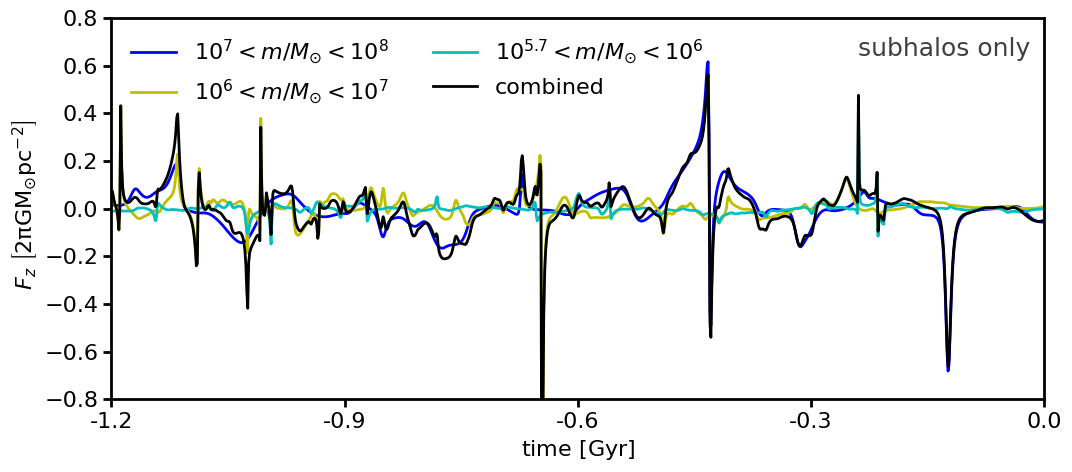

In [41]:
fig = plt.figure(1)
fig.set_size_inches(11, 5)
ax = plt.subplot(111)
ax.plot(time_Gyr.value, f_net_subhalos_7, color='b', lw=2,label=r'$10^7 < m / M_{\odot} < 10^8$')
ax.plot(time_Gyr.value, f_net_subhalos_6, color='y', lw=2,label=r'$10^6 < m / M_{\odot} < 10^7$')
ax.plot(time_Gyr.value, f_net_subhalos_below_6, color='c', lw=2,label=r'$10^{5.7} < m / M_{\odot} < 10^6$')
ax.plot(time_Gyr.value, f_net_subhalos, color='k',lw=2, label='combined')
leg = ax.legend(fontsize=16, loc=2,framealpha=1.,ncol=2, frameon=False)
ax.set_xlabel('time '+r'$\left[\rm{Gyr}\right]$')
ax.set_ylabel(r'$\ F_{z} \ \left[\rm{2\pi G M_{\odot}} \rm{pc^{-2}}\right]$', fontsize=16)
ax.annotate('subhalos only', xy=(0.8, 0.9), xycoords='axes fraction', color='0.25', fontsize=18)
ax.set_ylim(-0.8, 0.8)
ax.set_xlim(-1.2, 0.0)
ax.set_xticks([-1.2, -0.9, -0.6, -0.3, 0.0])
ax.set_xticklabels([-1.2, -0.9, -0.6, -0.3, 0.0])
plt.tight_layout()
#plt.show()
plt.savefig('subhalo_force_figure_split.pdf')

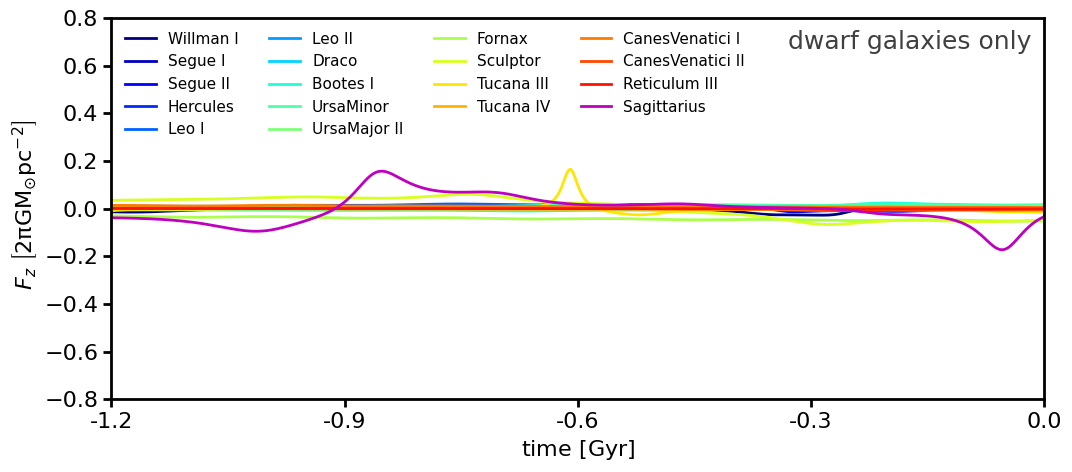

In [42]:
fig = plt.figure(1)
fig.set_size_inches(11, 5)
ax = plt.subplot(111)

i_max = len(force_dphsr)-1
for i in range(0, len(dsphr_orbit_params)):
    if i==i_max:
        col = 'm'
    else:
        col = dwarf_galaxy_colors[i]
    label = dwarf_galaxy_names[i]
    ax.plot(time_Gyr.value, force_dphsr[i], color=col, lw=2.,label=dwarf_galaxy_names[i])
    
ax.legend(fontsize=11,ncol=4,loc=2,framealpha=0.7,frameon=False)
ax.set_xlabel('time '+r'$\left[\rm{Gyr}\right]$')
ax.set_ylabel(r'$\ F_{z} \ \left[\rm{2\pi G M_{\odot}} \rm{pc^{-2}}\right]$', fontsize=16)
ax.annotate('dwarf galaxies only', xy=(0.725, 0.92), xycoords='axes fraction', color='0.25', fontsize=18)
ax.set_ylim(-0.8, 0.8)
ax.set_xlim(-1.2, 0.0)
ax.set_xticks([-1.2, -0.9, -0.6, -0.3, 0.0])
ax.set_xticklabels([-1.2, -0.9, -0.6, -0.3, 0.0])

plt.tight_layout()
plt.savefig('force_figure_dsphr.pdf')

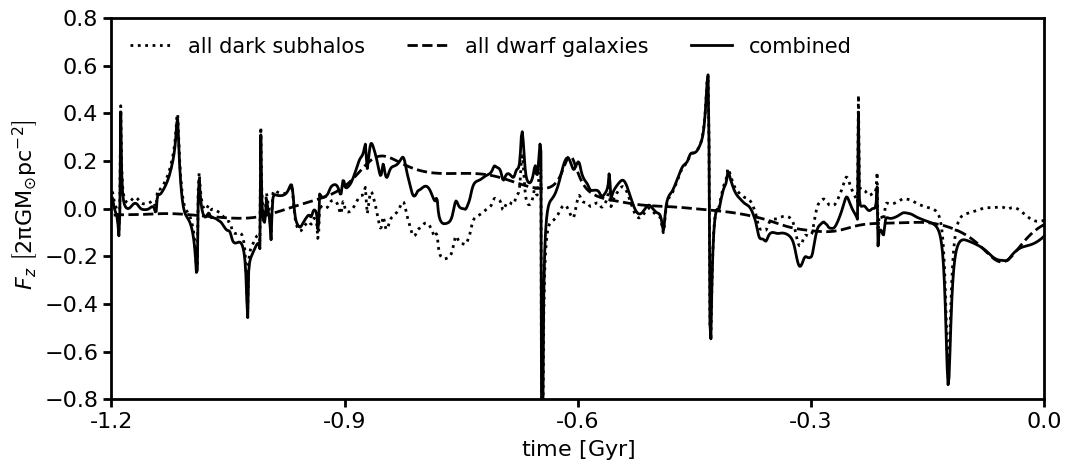

In [43]:
fig = plt.figure(1)
fig.set_size_inches(11, 5)
ax = plt.subplot(111)
ax.plot(time_Gyr.value, f_net_subhalos, color='k',lw=2, label='all dark subhalos', linestyle=':')
ax.plot(time_Gyr.value, fnet_dsphr, color='k', lw=2,label='all dwarf galaxies', linestyle='--')
ax.plot(time_Gyr.value, fnet_dsphr + f_net_subhalos, color='k', lw=2,label='combined')
ax.legend(fontsize=15,loc=2,framealpha=1, ncol=3, frameon=False)
ax.set_xlabel('time '+r'$\left[\rm{Gyr}\right]$')
ax.set_ylabel(r'$\ F_{z} \ \left[\rm{2\pi G M_{\odot}} \rm{pc^{-2}}\right]$', fontsize=16)

ax.set_ylim(-0.8, 0.8)
ax.set_xlim(-1.2, 0.0)
ax.set_xticks([-1.2, -0.9, -0.6, -0.3, 0.0])
ax.set_xticklabels([-1.2, -0.9, -0.6, -0.3, 0.0])

plt.tight_layout()
plt.savefig('force_figure_combined.pdf')

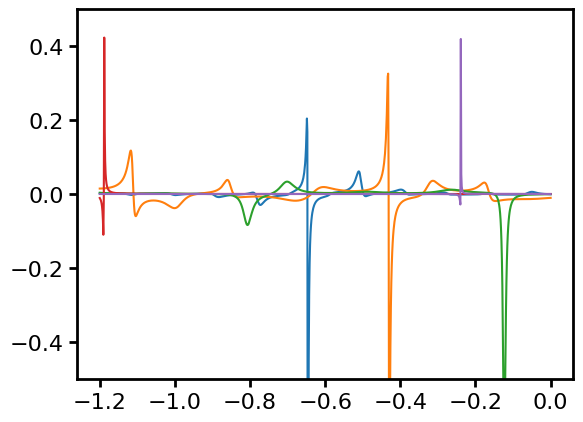

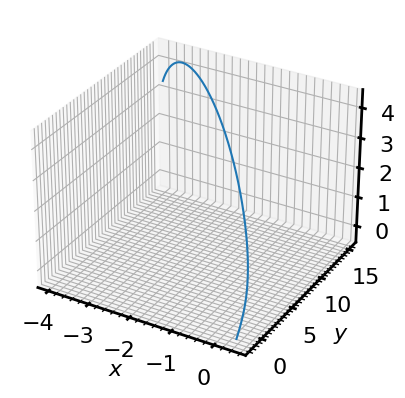

In [44]:
f_max = []
for fi in f_array_list_subhalos:
    f_max.append(max(np.absolute(fi)))
ids_max = np.argsort(f_max)[::-1]
for i in range(0, 5):
    idx = ids_max[i]
    plt.plot(time_Gyr, f_array_list_subhalos[idx])
plt.ylim(-0.5, 0.5)
plt.show()
orb = realization.subhalo_orbits[ids_max[3]]
t = disc.time_Gyr_eval
orb.plot3d()